# Ejercicio Final - Prueba de modelos - Logistic Regression
## La tarea consiste en resolver un challenge de Machine Learning, Diabetes Prediction, en equipo aplicando los conocimientos adquiridos en el módulo de Aprendizaje Supervisado y No Supervisado, así como los modelos descritos en el documento MLpedia.
## El challenge simula un caso real de Data Science, donde no existe una única solución correcta, sino decisiones justificadas en base a datos, métricas y criterios técnicos

In [2]:
#Importamos las librerías necesarias

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.datasets import load_diabetes
from sklearn.preprocessing import LabelEncoder, label_binarize

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


In [3]:
df = pd.read_csv('train.csv', sep=';')
df.head()

,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,...,gender,ethnicity,education_level,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes
0,0,31,1,45,7.7,6.8,6.1,33.4,0.93,112,...,Female,Hispanic,Highschool,Lower-Middle,Current,Employed,0,0,0,1.0
1,1,50,2,73,5.7,6.5,5.8,23.8,0.83,120,...,Female,White,Highschool,Upper-Middle,Never,Employed,0,0,0,1.0
2,2,32,3,158,8.5,7.4,9.1,24.1,0.83,95,...,Male,Hispanic,Highschool,Lower-Middle,Never,Retired,0,0,0,0.0
3,3,54,3,77,4.6,7.0,9.2,26.6,0.83,121,...,Female,White,Highschool,Lower-Middle,Current,Employed,0,1,0,1.0
4,4,54,1,55,5.7,6.2,5.1,28.8,0.90,108,...,Male,White,Highschool,Upper-Middle,Never,Retired,0,1,0,1.0


# EDA

Se trata de un dataset con etiquetas, por lo que será Aprendizaje Supervisado

In [4]:
#2- Exploración y Preprocesamiento
df.duplicated().sum() # Verificar filas duplicadas

print("\nInformación del dataset:")
print(df.info())

#2.1 Valores nulos
print("\nValores nulos por columna:")
print(df.isnull().sum())

#Descripción
print("\nDescripción estadística:")
print(df.describe())



Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 26 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   id                                  700000 non-null  int64  
 1   age                                 700000 non-null  int64  
 2   alcohol_consumption_per_week        700000 non-null  int64  
 3   physical_activity_minutes_per_week  700000 non-null  int64  
 4   diet_score                          700000 non-null  float64
 5   sleep_hours_per_day                 700000 non-null  float64
 6   screen_time_hours_per_day           700000 non-null  float64
 7   bmi                                 700000 non-null  float64
 8   waist_to_hip_ratio                  700000 non-null  float64
 9   systolic_bp                         700000 non-null  int64  
 10  diastolic_bp                        700000 non-null  int64  
 11  

In [5]:
df.shape # (número de filas, número de columnas)
target = "diagnosed_diabetes" # Nombre de la columna objetivo

# Identificar columnas que parecen ser booleanas ocultas
def is_hidden_boolean(series):
    values = set(series.dropna().unique())
    return values.issubset({0, 1})

hidden_bools = [
    col for col in df.columns 
    if df[col].dtype in ["float64", "int64"]
    and is_hidden_boolean(df[col])
]
df[hidden_bools] = df[hidden_bools].astype("bool")
print("Columnas que parecen ser booleanas ocultas:", hidden_bools)

Columnas que parecen ser booleanas ocultas: ['family_history_diabetes', 'hypertension_history', 'cardiovascular_history', 'diagnosed_diabetes']



Matriz de correlación completa:
                                          id       age  \
id                                  1.000000  0.001615   
age                                 0.001615  1.000000   
alcohol_consumption_per_week        0.001614  0.003295   
physical_activity_minutes_per_week  0.012424 -0.029101   
diet_score                          0.000878 -0.001898   
sleep_hours_per_day                -0.002118 -0.001286   
screen_time_hours_per_day          -0.000716 -0.002313   
bmi                                -0.000692  0.062958   
waist_to_hip_ratio                 -0.000144  0.044654   
systolic_bp                         0.001546  0.502894   
diastolic_bp                       -0.000234  0.188403   
heart_rate                         -0.000764  0.004294   
cholesterol_total                   0.000518  0.283155   
hdl_cholesterol                    -0.000368  0.002654   
ldl_cholesterol                     0.000129  0.245503   
triglycerides                       0.0

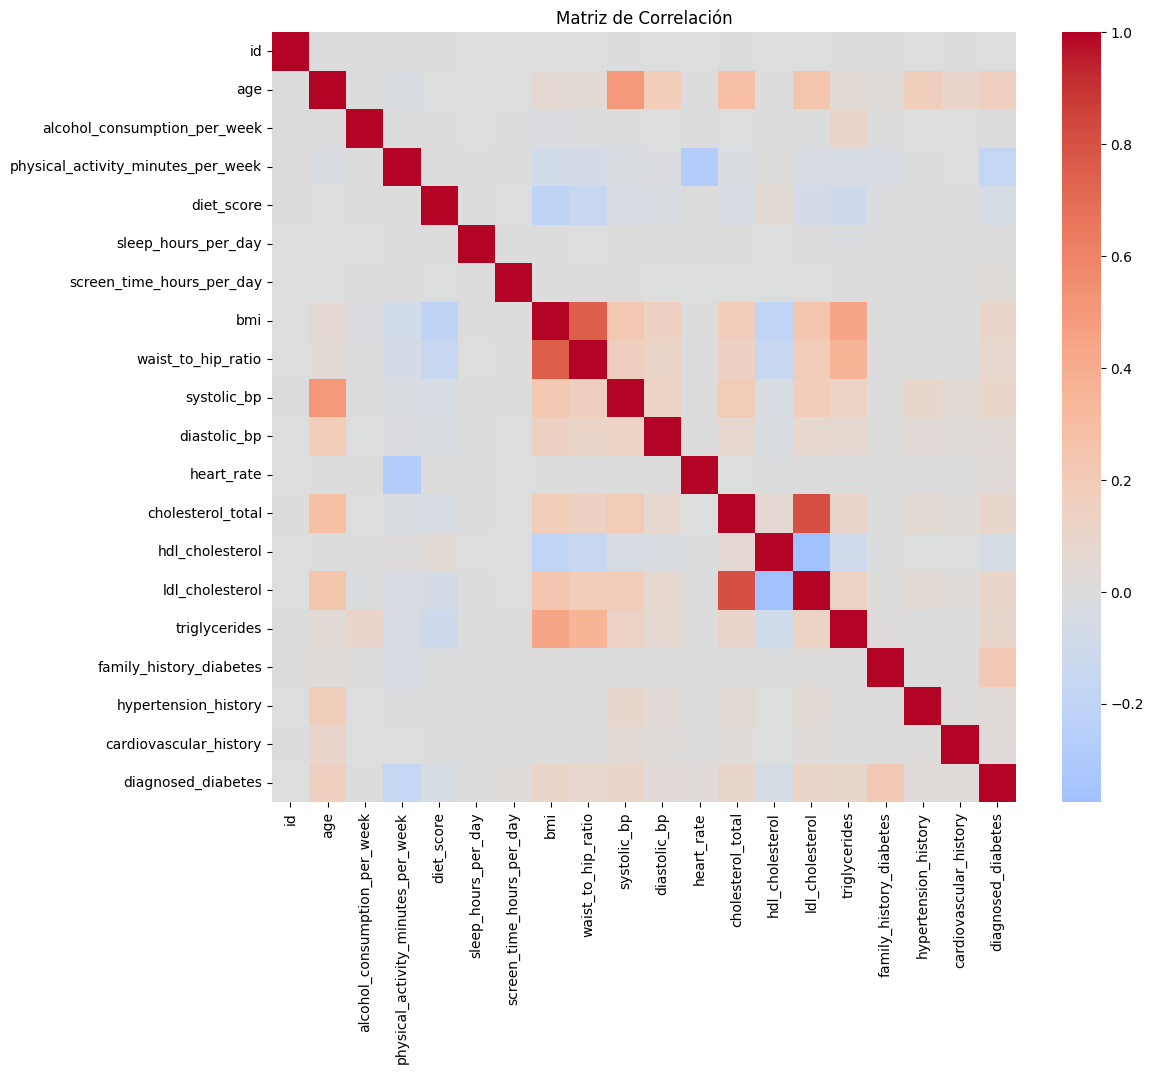

In [6]:
#2.2 Correlación de las variables
correlation_matrix = df.corr(numeric_only=True)

# Mostrar la matriz completa
print("\nMatriz de correlación completa:")
print(correlation_matrix)

# Para mostrar de manera más limpia: top correlaciones positivas y negativas
corr_pairs = correlation_matrix.unstack().sort_values(ascending=False)
# Remover autocorrelaciones (1.0)
corr_pairs = corr_pairs[corr_pairs < 1.0]

print("\n=== TOP 10 CORRELACIONES POSITIVAS ===")
print(corr_pairs.head(5))

print("\n=== TOP 10 CORRELACIONES NEGATIVAS (más negativas) ===")
print(corr_pairs.tail(5))

# Muestro con un heatmap la matriz de correlación

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación')
plt.show()

Relaciones a destacar:
1. La correlación más alta del dataset se observa entre "colesterol total" y "LDL" (r = 0.81), el LDL es el principal transportador de colesterol desde el hígado hacia los tejidos, por lo que es esperable clínicamente.
2. Fuerte correlación positiva entre "BMI" (Índice de Masa Corporal) y "waist-to-hip ratio" (r = 0.76, Cociente entre el perímetro de la cintura y el de la cadera), ambos capturan info sobre grasa corporal.
3. La "edad" presenta una correlación moderada con la "presión arterial sistólica" (r = 0.50), reflejando el aumento de riesgo cardiovascular con la edad.
4. La "actividad física" se correlaciona negativamente con la "frecuencia cardíaca" (r = −0.27), lo que sugiere mejores condiciones cardiovasculares en individuos más activos.
5. El "diet score" muestra una correlación negativa con el "BMI" (r = −0.20), indicando que una mejor calidad de dieta se asocia con menor índice de masa corporal.
6. En relación con la "diabetes diagnosticada", las correlaciones son bajas a moderadas, destacando "antecedentes familiares" (r = 0.21) y "edad" (r = 0.16).
7. Se observa que "BMI", "waist-to-hip ratio" y "presión arterial" muestran correlaciones positivas con la diabetes.
8. Los "niveles de LDL y triglicéridos" presentan correlaciones positivas débiles con la diabetes.
9. El "HDL colesterol" se correlaciona negativamente con diabetes.

Para fuertes correlaciones, como los puntos 1 y 2, podemos elegir mantener solo uno pero como usamos regularización y nuestro objetivo es una máxima capacidad predictiva, los mantendremos.

La mayoría de correlaciones con la variable objetivo son bajas, lo que sugiere un fenómeno multifactorial y justifica el uso de modelos multivariantes.

In [7]:
from sklearn.preprocessing import StandardScaler

#3- Selección de variables y división del Dataset

# Creamos objetivo binario desde num; num=0 significa no hay efermedad
# y si es mayor es que la puede haber
df['target'] = (df['diagnosed_diabetes'] > 0).astype(int)

#Definir la Y como las variables objetivo
y = df['target'] # Use the newly created target

# Definir X como las características numéricas, excluyendo el target y columnas no útiles
X = df.drop(['target', 'diagnosed_diabetes', 'id'], axis=1)

# Codificación de la variable objetivo
y_encoded = df['target'].to_numpy() # (n,)

# (Opcional) y_bin SOLO si lo necesitas para ROC/AUC tipo multilabel/OVA manual
y_bin = label_binarize(y_encoded, classes=np.unique(y_encoded))  # (n,1) en binario


# Dividir los datos para entrenar 80% y probar 20%, asegurando la estratificación por la variable objetivo
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("\nTamaños:")
print("X_train:", X_train.shape)
print("X_test :", X_test.shape)
print("y_train:", y_train.shape)
print("y_test :", y_test.shape)

# Codificar variables categóricas
categorical_cols = ['gender', 'ethnicity', 'education_level', 'income_level', 'smoking_status', 'employment_status']
for col in categorical_cols:
    le_col = LabelEncoder()
    X_train[col] = le_col.fit_transform(X_train[col])
    X_test[col] = le_col.transform(X_test[col])

# Escalar solo las características de X una vez definidas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Tamaños:
X_train: (560000, 24)
X_test : (140000, 24)
y_train: (560000,)
y_test : (140000,)


Entrenamiento del Modelo: Utiliza la regresión logística para entrenar un modelo con el conjunto de entrenamiento.

In [8]:
#Inicializo el modelo con Regresión logística
from sklearn.linear_model import LogisticRegression


model = LogisticRegression(solver='liblinear', random_state=42)

params = {'fit_intercept': [True, False]}

# Use an appropriate scoring metric for classification, e.g., f1_score
# Reduced cv to 3 to mitigate single-class issues in folds due to class imbalance
# Added error_score='raise' to get a more detailed traceback for fit failures
grid_search = GridSearchCV(model, params, cv=3, scoring=make_scorer(f1_score), error_score='raise')
grid_search.fit(X_train_scaled, y_train)
# Mejor modelo
best_model = grid_search.best_estimator_

# Set 'model' to the best model found by GridSearchCV for subsequent use
model = best_model

print("\nMejores hiperparámetros encontrados:")
print(grid_search.best_params_)
# Modelo seleccionado listo para usar
print("\nModelo seleccionado listo para usar.") 
print(model)



Mejores hiperparámetros encontrados:
{'fit_intercept': True}

Modelo seleccionado listo para usar.
LogisticRegression(random_state=42, solver='liblinear')


In [9]:
from sklearn.pipeline import Pipeline

#Obtengo los resultados para cada uno de los funciones de regresión
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(solver='liblinear', random_state=42))
])

params = {
    'clf__fit_intercept': [True, False]
}

grid = GridSearchCV(
    pipe,
    params,
    cv=3,
    scoring='f1'
)

grid.fit(X_train, y_train)

model = grid.best_estimator_

# Predicción limpia
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

In [10]:
from sklearn.metrics import roc_auc_score, roc_curve, classification_report

#Cálculo de métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

print("===== MÉTRICAS DEL MODELO ====")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

print("\n===== CLASSIFICATION REPORT ====")
print(classification_report(y_test, y_pred, target_names=["No Diabetes", "Diabetes"]))

===== MÉTRICAS DEL MODELO ====
Accuracy: 0.6641
Precision: 0.6820
Recall: 0.8637
F1-Score: 0.7622
AUC-ROC: 0.6946

===== CLASSIFICATION REPORT ====
              precision    recall  f1-score   support

 No Diabetes       0.60      0.33      0.43     52739
    Diabetes       0.68      0.86      0.76     87261

    accuracy                           0.66    140000
   macro avg       0.64      0.60      0.60    140000
weighted avg       0.65      0.66      0.64    140000



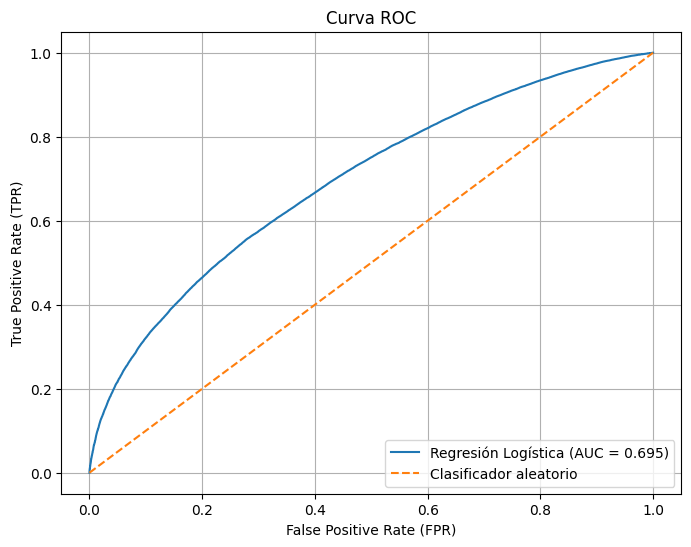

In [11]:
#Dibujamos la curva ROC para ver nuestra regresión logística para clasificar el dataset

fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Regresión Logística (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Clasificador aleatorio")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

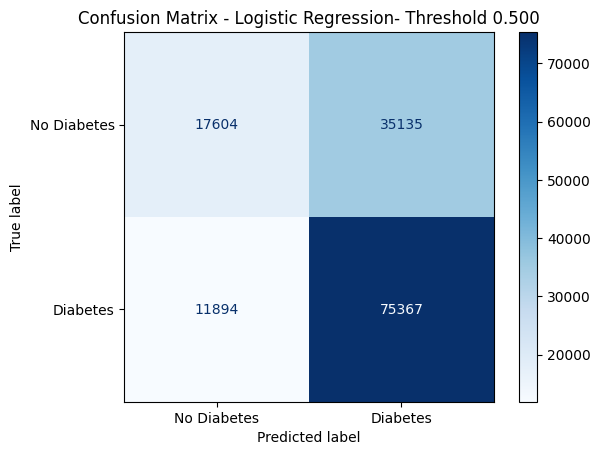

In [12]:
# Threshold para mostrar en la gráfica
threshold = 0.5

# Calcular matriz
cm = confusion_matrix(y_test, y_pred)

# Plot con ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["No Diabetes", "Diabetes"]
)

disp.plot(cmap="Blues", values_format="d")
plt.title(f"Confusion Matrix - Logistic Regression- Threshold {threshold:.3f}")
plt.show()

c:\Users\seje\AppData\Local\anaconda3\envs\Jesuspython\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Optimal threshold using Youden's J: 0.129
Threshold for recall >= 0.97 with max precision: 0.105

Metrics with chosen threshold (0.105):
Accuracy:  0.6248
Precision: 0.6291
Recall:    0.9700
F1-Score:  0.7632
AUC-ROC:   0.6186


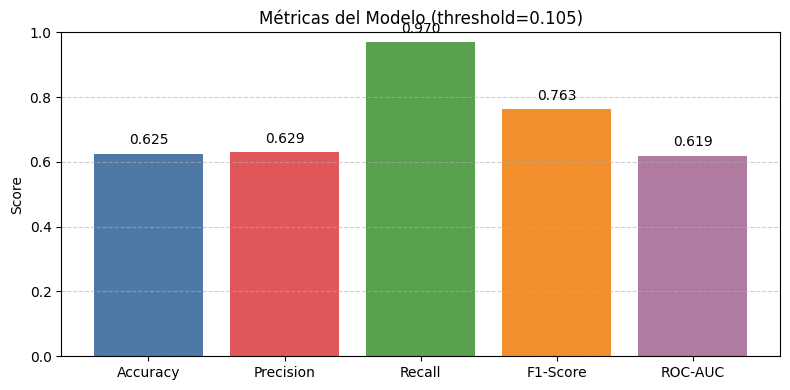

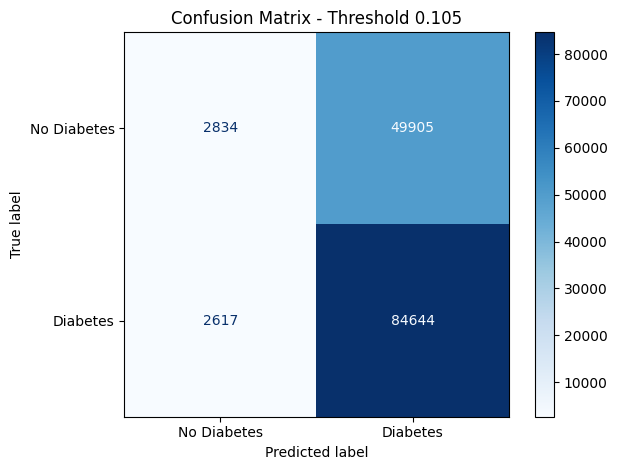

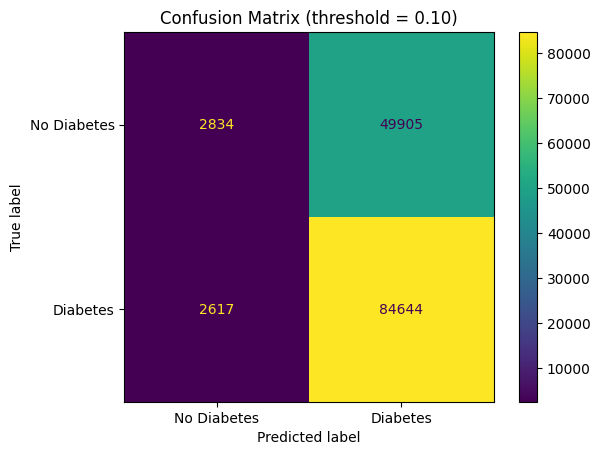

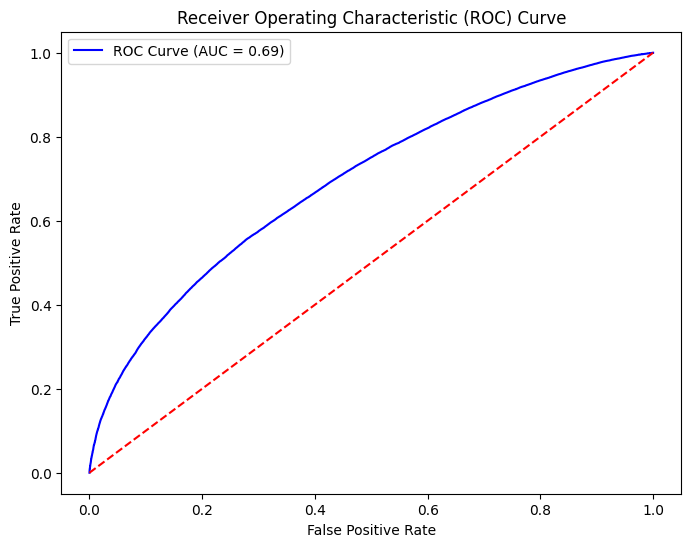

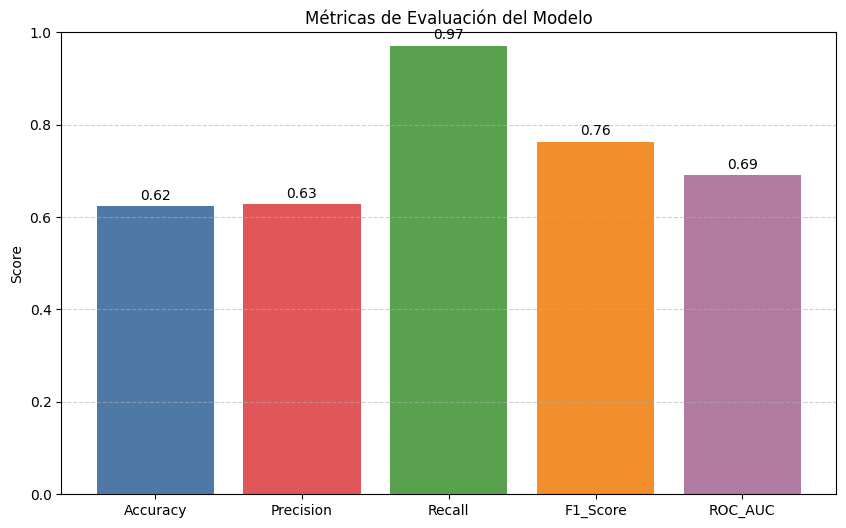

Accuracy  : 0.6248428571428571
Precision : 0.6290942333276353
Recall    : 0.9700095116948007
F1_Score  : 0.7632117578107389
ROC_AUC   : 0.6186187779147659


In [22]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_curve, precision_recall_curve,
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay
)

# --- Asegurar y_test 1D ---
y_test_1d = y_test.to_numpy() if hasattr(y_test, "to_numpy") else np.asarray(y_test)

# --- Probabilidades (IMPORTANTE: usar el mismo tipo de X que en entrenamiento) ---
# Si entrenaste con X_train_scaled, debes predecir con X_test_scaled:
X_for_pred = X_test_scaled  

y_pred_proba = model.predict_proba(X_for_pred)[:, 1]

# --- Threshold óptimo con Youden's J ---
fpr, tpr, thresholds_roc = roc_curve(y_test_1d, y_pred_proba)
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold_youden = thresholds_roc[optimal_idx]
print(f"Optimal threshold using Youden's J: {optimal_threshold_youden:.3f}")

# --- Threshold para recall alto (p.ej. >= 0.90) maximizando precision ---
precision_vals, recall_vals, thresholds_pr = precision_recall_curve(y_test_1d, y_pred_proba)

target_recall = 0.97
valid = recall_vals[:-1] >= target_recall  # thresholds_pr tiene len = len(precision_vals)-1

if np.any(valid):
    best_idx_within_valid = np.argmax(precision_vals[:-1][valid])
    optimal_threshold_recall = thresholds_pr[valid][best_idx_within_valid]
    print(f"Threshold for recall >= {target_recall:.2f} with max precision: {optimal_threshold_recall:.3f}")
else:
    print(f"No threshold achieves recall >= {target_recall:.2f}. Using Youden's threshold instead.")
    optimal_threshold_recall = optimal_threshold_youden

# --- Elegir threshold ---
chosen_threshold = optimal_threshold_recall

# --- Predicción con threshold elegido ---
y_pred_opt = (y_pred_proba >= chosen_threshold).astype(int)

# --- Métricas ---
accuracy_opt = accuracy_score(y_test_1d, y_pred_opt)
precision_opt = precision_score(y_test_1d, y_pred_opt, zero_division=0)
recall_opt = recall_score(y_test_1d, y_pred_opt, zero_division=0)
f1_opt = f1_score(y_test_1d, y_pred_opt, zero_division=0)
roc_auc_opt = roc_auc_score(y_test_1d, y_pred_proba)  # AUC no cambia con threshold

colors = ["#4E79A7", "#E15759",  "#59A14F", "#F28E2B", "#B07AA1"] 

print(f"\nMetrics with chosen threshold ({chosen_threshold:.3f}):")
print(f"Accuracy:  {accuracy_opt:.4f}")
print(f"Precision: {precision_opt:.4f}")
print(f"Recall:    {recall_opt:.4f}")
print(f"F1-Score:  {f1_opt:.4f}")
print(f"AUC-ROC:   {roc_auc_opt:.4f}")

# --- Gráfica de barras con valores encima ---
metrics = {
    "Accuracy": accuracy_opt,
    "Precision": precision_opt,
    "Recall": recall_opt,
    "F1-Score": f1_opt,
    "ROC-AUC": roc_auc_opt
}

names = list(metrics.keys())
values = list(metrics.values())

plt.figure(figsize=(8, 4))
bars = plt.bar(names, values, color=colors)   # Mostrar barras
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title(f"Métricas del Modelo (threshold={chosen_threshold:.3f})")
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Valores sobre cada barra
for b in bars:
    h = b.get_height()
    plt.text(
        b.get_x() + b.get_width() / 2,
        h + 0.02,
        f"{h:.3f}",
        ha="center",
        va="bottom"
    )

plt.tight_layout()
plt.show()

# --- Matriz de confusión ---
cm_opt = confusion_matrix(y_test_1d, y_pred_opt)
disp_opt = ConfusionMatrixDisplay(confusion_matrix=cm_opt, display_labels=["No Diabetes", "Diabetes"])
disp_opt.plot(cmap="Blues", values_format="d")
plt.title(f"Confusion Matrix - Threshold {chosen_threshold:.3f}")
plt.tight_layout()
plt.show()

disp = ConfusionMatrixDisplay(confusion_matrix=cm_opt, display_labels=["No Diabetes","Diabetes"])
disp.plot(values_format='d')
plt.title(f'Confusion Matrix (threshold = {chosen_threshold:.2f})')
plt.show()

#Dibujamos la curva ROC para ver nuestra regresión logística para clasificar el dataset

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()




# --- Métricas ---
Accuracy = accuracy_score(y_test_1d, y_pred_opt)
Precision = precision_score(y_test_1d, y_pred_opt, zero_division=0)
Recall = recall_score(y_test_1d, y_pred_opt, zero_division=0)
F1_Score = f1_score(y_test_1d, y_pred_opt, zero_division=0)
ROC_AUC = roc_auc_score(y_test_1d, y_pred_proba) 

metrics = {
    "Accuracy": Accuracy, "Precision": Precision, "Recall": Recall, "F1_Score": F1_Score, "ROC_AUC": 0.69
}

colors = ["#4E79A7", "#E15759",  "#59A14F", "#F28E2B", "#B07AA1"] 

plt.figure(figsize=(10,6))
bars = plt.bar(metrics.keys(), metrics.values(), color=colors)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        height * 1.01, 
        f'{height:.2f}', 
        ha='center', 
        va='bottom',
        fontsize=10
    )

plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('Métricas de Evaluación del Modelo')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

print("Accuracy  :", Accuracy)
print("Precision :", Precision)
print("Recall    :", Recall)
print("F1_Score  :", F1_Score)
print("ROC_AUC   :", ROC_AUC)


COMPARATAIVA CON Thresold de 0.5
    ===== MÉTRICAS DEL MODELO ====
    Accuracy: 0.6636 -> IDEM
    Precision: 0.6811 -> 0,1 MAS
    Recall: 0.8657 -> 0,4 MENOS
    F1-Score: 0.7624 -> IDEM
    AUC-ROC: 0.6944 -> IDEM



Conclusiones para Logistic Regression:
La regresión logística es fácil de interpretar y detecta bien los casos de diabetes, aunque su capacidad predictiva es limitada porque puede no ver relaciones no lineales entre variables.